## One-day-ahead prediction on stock value in USD
$$ Traded Value[m USD] = Traded Volume [m shares] \times Closing Price [USD]$$
<br>
<br>
Given the limited time to spend on this project, I would decompose the question into: <br> 
1) predicting trading volume, and
<br>
2) predicting stock closing price
<br>
although there are an abundance of literatures suggesting relationships between price/return and trading volume.
<br>


## I. Predicting Stock closing price
###  1. Load the data

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
stocks = pd.read_csv('stock.csv')
stocks['Date'] = pd.to_datetime(stocks['Date'])
stocks['Date'] = stocks['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
stocks.head()

,Date,ID,Volume,Spread,Volatility,Price,Sentiment
0,2012-02-01,IROSROA,518.195133,0.001272,0.118802,1125.148876,-1.734483
1,2012-02-01,LBQCYGN,782.416185,0.001976,0.141883,14.873362,0.243940
2,2012-02-01,GZMNIJI,792.203352,0.002029,0.144689,15.577075,0.111437
3,2012-02-01,PREGXXP,794.471386,0.001169,0.111836,724.542317,-0.080213
4,2012-02-01,TJXKVVW,660.684739,0.002092,0.152536,12.515318,0.621398


In [2]:
fx = pd.read_csv('fx.csv')
fx.head(3)

,Date,US/UK,JP/US
0,2012-01-02,1.5537,76.98
1,2012-01-03,1.5655,76.67
2,2012-01-04,1.5638,76.68


In [3]:
classification = pd.read_csv('classification.csv')
classification.head(3)

,ID,Country
0,IROSROA,JP
1,LBQCYGN,US
2,GZMNIJI,US


In [4]:
stocks = stocks.merge(classification, how = 'left')
stocks = stocks.merge(fx, how = 'left', on = 'Date')

#### on FX rate
I avoided decomposing **closing price in USD** into **closing price in local currency** and **FX rate against USD** as this would be another element to make predictions on. Although there are studies done on FX rate forecast based on historical FX rates alone using statistical and ML models, since I am not provided with macro economics data and given the time limit, I decided to convert all prices into USD using the historical FX rates provided and make the stock price prediction in USD directly. 

In [5]:
stocks['Price USD'] = np.where(stocks['Country'] == 'JP', stocks['Price']/stocks['JP/US'], 
                              np.where(stocks['Country'] == 'UK', stocks['Price'] * stocks['US/UK'], stocks['Price']))
stocks.head()

,Date,ID,Volume,Spread,Volatility,Price,Sentiment,Country,US/UK,JP/US,Price USD
0,2012-02-01,IROSROA,518.195133,0.001272,0.118802,1125.148876,-1.734483,JP,1.5849,76.11,14.783194
1,2012-02-01,LBQCYGN,782.416185,0.001976,0.141883,14.873362,0.243940,US,1.5849,76.11,14.873362
2,2012-02-01,GZMNIJI,792.203352,0.002029,0.144689,15.577075,0.111437,US,1.5849,76.11,15.577075
3,2012-02-01,PREGXXP,794.471386,0.001169,0.111836,724.542317,-0.080213,JP,1.5849,76.11,9.519673
4,2012-02-01,TJXKVVW,660.684739,0.002092,0.152536,12.515318,0.621398,UK,1.5849,76.11,19.835527


###  2 Explore the data
<br>
I originally considered using Auto-Regressive Integrated Moving Average (ARIMA) as stock prices are generally non-stationary and auto-correlated. <br>
See below:

In [6]:
def stock_df(stocks, ticker):
    df = stocks[stocks['ID'] == ticker][['Date','Country','Volume','Volatility','Price USD','Sentiment','Spread']]
    df.fillna(method = 'ffill', inplace = True) #in case there's no data point, fill with previous day data point
    return df

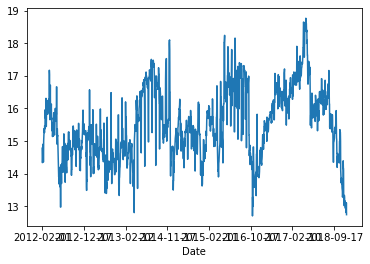

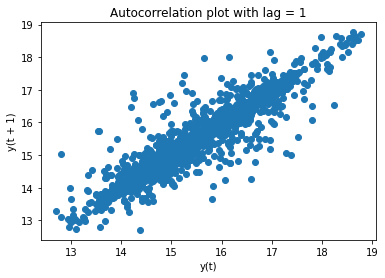

In [7]:
ticker = 'IROSROA'
df = stock_df(stocks, ticker).set_index('Date')
df['Price USD'].plot()

import matplotlib.pyplot as plt
from pandas.plotting import lag_plot

plt.figure()
lag_plot(df['Price USD'], lag=1)
plt.title('Autocorrelation plot with lag = 1')
plt.show()

However, multiple publications suggested that LSTM provides superior performance to ARIMA in stock market predictions [1][2].
<br>
<br>
This is likely because the non-linearity in the data, as we can see in another stock example below.

<AxesSubplot:xlabel='Date'>

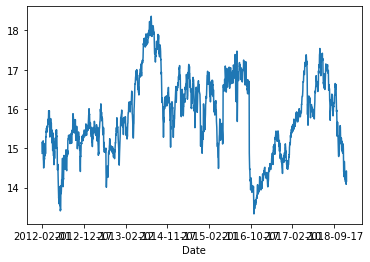

In [8]:
ticker = 'LBQCYGN'
df = stock_df(stocks, ticker).set_index('Date')
df['Price USD'].plot()

We can see from the 2 examples that the price series is nonlinear and nonstationary. 

###  2. LSTM models & Model training
#### 2.1 Standard LSTM

<br>
I explore the results with randomly one US stock and one non-US stock.

In [9]:
ticker = 'LBQCYGN' # I start by taking the first US stock as an example

df = stocks[stocks['ID'] == ticker][['Date','Price USD','Sentiment']].set_index('Date')
df.fillna(method = 'ffill', inplace = True) #in case there's no price, fill with previous day close
df.head(3)

,Price USD,Sentiment
Date,,
2012-02-01,14.873362,0.243940
2012-03-01,15.163614,-0.130350
2012-04-01,15.098638,0.178536


In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1)) 
px_norm = scaler.fit_transform(df['Price USD'].values.reshape(-1,1))

In [11]:
def df_to_XY(px_norm, window_size=5):#test 5, 10, 15, 20, 30
    X = []
    Y = []
    for i in range(len(px_norm)-window_size):
        X.append([pair for pair in px_norm[i:i+window_size]])
        Y.append(px_norm[i+window_size, 0])
    return np.array(X), np.array(Y)

In [12]:
window_size = 10
X0, Y0 = df_to_XY(px_norm, window_size)
X0.shape, Y0.shape

((1816, 10, 1), (1816,))

In [20]:
def split_data(X, Y, train_split = 0.8): #default train/test split is 80/20

    split_index = int(Y.shape[0] * train_split)
    
    X_train, Y_train = X[:split_index], Y[:split_index]
    X_test, Y_test = X[split_index:], Y[split_index:]
    
    return X_train, Y_train, X_test, Y_test, split_index

In [21]:
X0_train, Y0_train, X0_test, Y0_test, split_index = split_data(X0, Y0)
X0_train.shape, Y0_train.shape, X0_test.shape, Y0_test.shape

((1452, 10, 1), (1452,), (364, 10, 1), (364,))

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

3 parameters need to be decided:
1) # of layers <br>
2) # unit <br>
3) dropout %

<br>
The optimal parameters should be obtained by comparing the deviation of the predicted results. 
In this model, I will set 1 input layer,  3 LSTM layers, each followed by a dropout layer, and a final dense layer as ouput.
<br>
I will set the unit number for each LSTM layer to be 100 and the dropout rate to be 0.1.

In [16]:
def LSTM_layers(input_row, input_col):
    model0 = Sequential()
    model0.add(LSTM(units=100,return_sequences=True,input_shape=(input_row, input_col)))
    model0.add(LSTM(units=100,return_sequences=True))
    model0.add(Dropout(0.1))
    model0.add(LSTM(units=100,return_sequences=True))
    model0.add(Dropout(0.1))
    model0.add(LSTM(units=100))
    model0.add(Dropout(0.1))
    model0.add(Dense(units=1))
    return model0

In [17]:
model0 = LSTM_layers(window_size, 1)
model0.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001))
model0.fit(X0_train,Y0_train, epochs=10) #batch size?

Epoch 1/10
46/46 [==============================] - 7s 40ms/step - loss: 0.0366
Epoch 2/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0067
Epoch 3/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0067
Epoch 4/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0066
Epoch 5/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0069
Epoch 6/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0065
Epoch 7/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0066
Epoch 8/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0059
Epoch 9/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0055
Epoch 10/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0057


12/12 [==============================] - 0s 12ms/step


([<matplotlib.axis.XTick at 0x1f8f213f5b0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

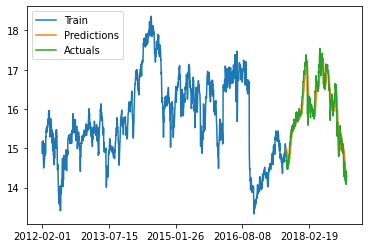

In [22]:
test_predictions0 = model0.predict(X0_test)
px_predict0 = scaler.inverse_transform(test_predictions0)
results0 = pd.DataFrame(data={'Test Predictions':px_predict0.flatten(), 
                              'Actuals':df.iloc[split_index+window_size:]['Price USD']})

import matplotlib.pyplot as plt
plt.plot(df.iloc[:split_index+window_size]['Price USD'])
plt.plot(results0[['Test Predictions', 'Actuals']])
plt.legend(['Train', 'Predictions', 'Actuals'], loc='upper left')
plt.xticks(np.arange(0, X0.shape[0], 400))

In [25]:
X0_test.shape

(364, 10, 1)

In [31]:
test_predictions0 .shape

(364, 1)

In [23]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape


def performance_measure(model, X, y, method = 'Standard LSTM'):
    predictions = model.predict(X).flatten()
    return pd.DataFrame({'MSE': mse(y, predictions), 
                         'MAE': mae(y, predictions), 
                         'MAPE': mape(y, predictions), 
                         'Accuracy': 1-mape(y, predictions)}, index = [method])

In [24]:
res0 = performance_measure(model0, X0_test, Y0_test.flatten())
res0

12/12 [==============================] - 0s 13ms/step


,MSE,MAE,MAPE,Accuracy
Standard LSTM,0.003729,0.048097,0.10379,0.89621


#### 2.2 LSTM with historical data and sentiment score pair
<br>
Intuitively it makes sense that **sentiment score** affect the stock price, and various research discusses the importance of incorporating sentiment in stock market predictions [3][4].
<br>
I will first explore the method used in "Stock price prediction using news sentiment analysis" by S. Mohan et al. [5] where the historical price and sentiment score are paired to for price prediction by LSTM. The pairs are 
$(Price_{t-1}, Sentiment Score_{t}),...,(Price_{t-m}, Sentiment Score_{t-m-1})$

In [32]:
sent_norm =  scaler.fit_transform(df['Sentiment'].values.reshape(-1,1)) # we also normalize the sentiment scores

In [33]:
df_norm = np.hstack((px_norm[1:], sent_norm[:-1])) # because we are pairing price with sentiment score with 1 step offset
df_norm.shape

(1825, 2)

In [35]:
#WINDOW_SIZE = 5
X1, Y1 = df_to_XY(df_norm, window_size)
X_train1, Y_train1, X_test1, Y_test1, split_index = split_data(X1, Y1)
X_train1.shape, Y_train1.shape, X_test1.shape, Y_test1.shape

((1452, 10, 2), (1452,), (363, 10, 2), (363,))

In [36]:
model1 = LSTM_layers(window_size, 2)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001))
model1.fit(X_train1,Y_train1, epochs=10)

Epoch 1/10
46/46 [==============================] - 8s 36ms/step - loss: 0.0365
Epoch 2/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0069
Epoch 3/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0067
Epoch 4/10
46/46 [==============================] - 2s 37ms/step - loss: 0.0067
Epoch 5/10
46/46 [==============================] - 2s 37ms/step - loss: 0.0066
Epoch 6/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0063
Epoch 7/10
46/46 [==============================] - 2s 36ms/step - loss: 0.0062
Epoch 8/10
46/46 [==============================] - 2s 36ms/step - loss: 0.0064
Epoch 9/10
46/46 [==============================] - 2s 36ms/step - loss: 0.0062
Epoch 10/10
46/46 [==============================] - 2s 35ms/step - loss: 0.0057


In [37]:
res1 = performance_measure(model1, X_test1, Y_test1.flatten(), 'Pair LSTM')
res1

12/12 [==============================] - 1s 14ms/step


,MSE,MAE,MAPE,Accuracy
Pair LSTM,0.004275,0.052414,0.111835,0.888165


#### 2.3 LSTM with historical data and sentiment score as additional row
<br>
Another way to incorporate sentiment score into the LSTM model mentioned in "FinBERT-LSTM: Deep Learning based stock price prediction using News Sentiment Analysis" by S. Halder [4] is to combine the closing stock price of 10 days and news sentiment on that day, resulting in the input layer shape to be 11 x 1.
<br>
I replicate the method below with rolling window size default to be 5.

In [38]:
def df_to_XY_add_sent(px_norm, sent_norm, window_size=5):#test 5, 10, 15, 20, 30
    X = []
    Y = []
    for i in range(len(px_norm)-window_size):
        X.append(np.concatenate((px_norm[i:i+window_size], sent_norm[i+window_size-1:i+window_size]), axis = 0))
        Y.append(px_norm[i+window_size, 0])
    return np.array(X), np.array(Y)

In [39]:
#WINDOW_SIZE = 5
X2, Y2 = df_to_XY_add_sent(px_norm, sent_norm, window_size)
X2.shape, Y2.shape

((1816, 11, 1), (1816,))

In [40]:
X_train2, Y_train2, X_test2, Y_test2, split_index = split_data(X2, Y2)
X_train2.shape, Y_train2.shape, X_test2.shape, Y_test2.shape

((1452, 11, 1), (1452,), (364, 11, 1), (364,))

In [41]:
model2 = LSTM_layers(window_size+1, 1)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001))
model2.fit(X_train2,Y_train2, epochs=10)

Epoch 1/10
46/46 [==============================] - 8s 39ms/step - loss: 0.0346
Epoch 2/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0065
Epoch 3/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0063
Epoch 4/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0056
Epoch 5/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0062
Epoch 6/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0057
Epoch 7/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0054
Epoch 8/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0049
Epoch 9/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0045
Epoch 10/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0054


In [42]:
res2 = performance_measure(model2, X_test2, Y_test2.flatten(), 'Pair LSTM')
res2

12/12 [==============================] - 1s 14ms/step


,MSE,MAE,MAPE,Accuracy
Pair LSTM,0.003061,0.041322,0.093633,0.906367


I combine the 3 performance measure tables. <br>
I can see that the Additional feature LSTM way of incorporating sentiment score performed better for this specific stock. 

In [43]:
summary = pd.concat([res0, res1, res2], axis = 0)
summary

,MSE,MAE,MAPE,Accuracy
Standard LSTM,0.003729,0.048097,0.103790,0.896210
Pair LSTM,0.004275,0.052414,0.111835,0.888165
Pair LSTM,0.003061,0.041322,0.093633,0.906367


###  3. Performance
I now put these code into functions and test on a few more stocks.

In [202]:
import toolkit as tk

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
stocks = tk.load_data()

In [171]:
ticker = 'LBQCYGN' #US stock

summary = tk.run_price_predict(ticker)
summary

12/12 [==============================] - 1s 10ms/step


,MSE,MAE,MAPE,Accuracy
Standard LSTM,0.002485,0.037492,0.081043,0.918957
LSTM Pair,0.003014,0.040175,0.088873,0.911127
LSTM Addl feature,0.002365,0.035588,0.079660,0.920340


In [175]:
for ticker in stocks['ID'].unique()[:5]:
    summary = tk.run_price_predict(ticker)
    print(ticker, summary)

12/12 [==============================] - 1s 13ms/step
IROSROA                         MSE       MAE      MAPE  Accuracy
Standard LSTM      0.005570  0.058927  0.252345  0.747655
LSTM Pair          0.007531  0.071464  0.252801  0.747199
LSTM Addl feature  0.005436  0.058968  0.239385  0.760615
12/12 [==============================] - 1s 13ms/step
LBQCYGN                         MSE       MAE      MAPE  Accuracy
Standard LSTM      0.002816  0.038682  0.084681  0.915319
LSTM Pair          0.002832  0.042268  0.086336  0.913664
LSTM Addl feature  0.002054  0.034322  0.074278  0.925722


From the above, we can see that for the stock examples, LSTM Additional Feature model provides performance improvement over the standard LSTM model. 


###  4. Stock price predictions
Given the above, I will use the **LSTM Additional Feature model** to predict the one-day-ahead stock price for the 100 stocks.

In [46]:
import toolkit as tk

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
stocks = tk.load_data()
stock_list = list(stocks['ID'].unique())

After testing a few different window sizes, I chose 5 as the window size as it gives the highest average accuracy in my sample.
<br>
**I commented out the code below as it takes a long time to run the prediction**.
<br>
**For price prediction results, see *Price USD predict.csv* file.**

In [ ]:
# result_dict = {}

# for ticker in stock_list:
#     df = tk.stock_df(stocks, ticker)
#     res_tup = tk.predict_LSTM_af(df, 5) 
#     result_dict[ticker] = {'Price in USD': res_tup[0], 
#                            'Accuracy': res_tup[1],
#                           'Country': df['Country'].values[0]}

# price_predict_USD = pd.DataFrame.from_dict(result_dict, orient='index')

In [ ]:
# price_predict_USD

In [ ]:
# price_predict_USD.to_csv('Price USD predict.csv') #It took a while to run so I put this into a file for later use

In [ ]:
# price_predict_USD['Accuracy'].median()

## II. Predicting Stock volume
###  1. Explore the data

<AxesSubplot:>

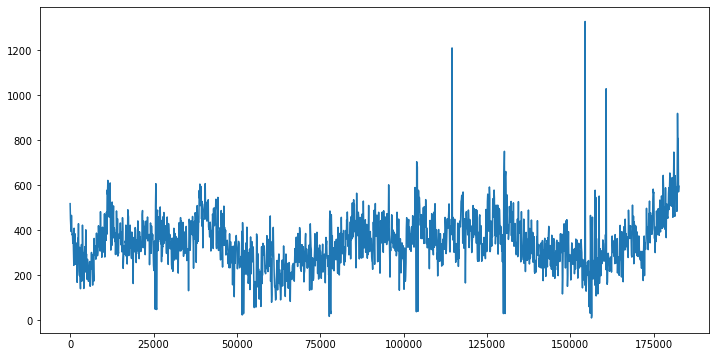

In [48]:
stocks = tk.load_data()

ticker = 'IROSROA' #take a random stock
df = tk.stock_df(stocks, ticker)
df['Volume'].plot(figsize = (12, 6))

Compared to the Price series, the Volume series is much more stationary. <br> 
I run ADF to test.

In [49]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Volume'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.886318
p-value: 0.046962
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


I can reject the null hypothesis at 5% significance level. The series is stationary.
<br>
I test another stock.

ADF Statistic: -3.529890
p-value: 0.007252
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


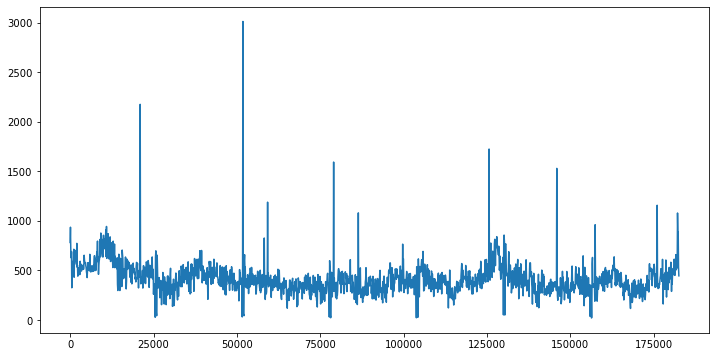

In [50]:
ticker = 'LBQCYGN'

df = tk.stock_df(stocks, ticker)
df['Volume'].plot(figsize = (12, 6))

result = adfuller(df['Volume'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

I reject the null hypothesis with significance level of 1%. 
<br>
The series is stationary.  

<br>
Intuitively, trading volume should be affected by Price/return, Volatility, and Sentiment, and that relationship is explored extensively already[6].<br>
I plot these 3 relationships below.

In [55]:
def linear_plot(ticker):
    df = tk.stock_df(stocks, ticker)[['Price USD','Volume','Volatility','Spread','Sentiment']]

    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize = (21,4))

    ax1.scatter(df['Price USD'], df['Volume'])
    ax1.set_xlabel('Volume')
    ax1.set_ylabel('Price USD')
    ax1.set_title('Pirce USD - Volume')

    ax2.scatter(df['Volatility'], df['Volume'])
    ax2.set_xlabel('Volatility')
    ax2.set_ylabel('Volume')
    ax2.set_title('Volatility - Volume')

    ax3.scatter(df['Sentiment'], df['Volume'])
    ax3.set_xlabel('Sentiment')
    ax3.set_ylabel('Volume')
    ax3.set_title('Sentiment - Volume')

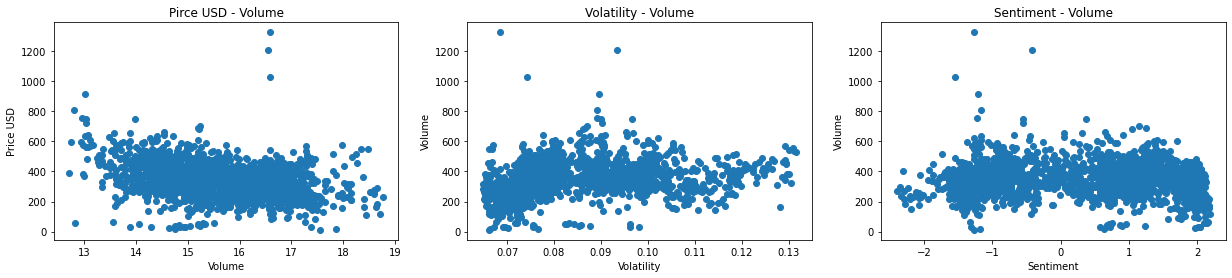

In [56]:
linear_plot('IROSROA')

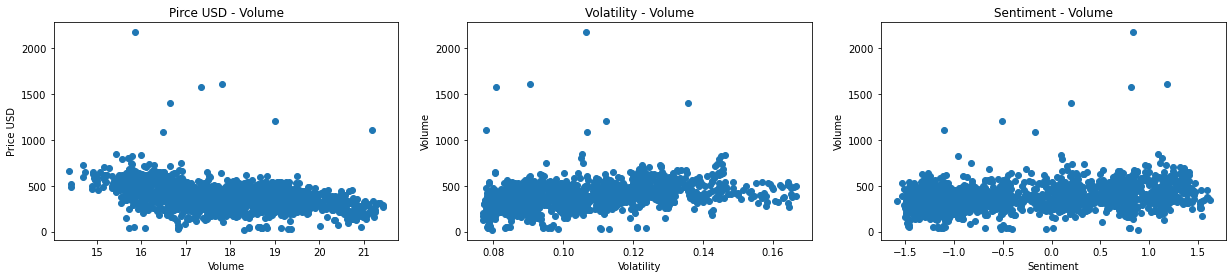

In [57]:
linear_plot('GZMNIJI')

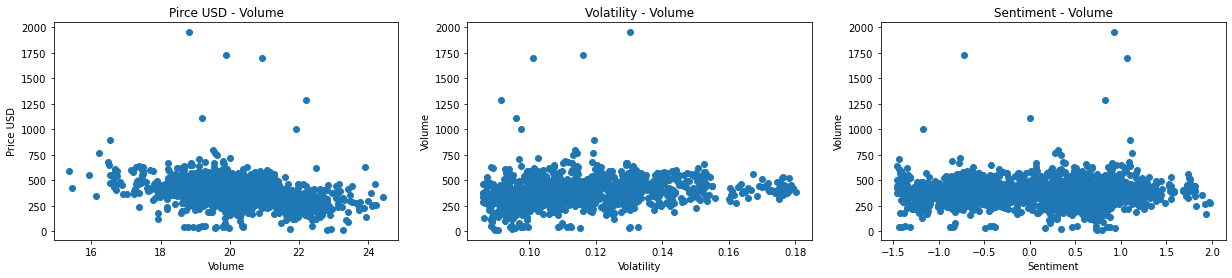

In [58]:
linear_plot('TJXKVVW')

Given the stationarity and linearity, as well as the relationship between Volume and Price, Volatility and Sentiment, I consider using multiple linear regression (MLR) model to predict the volume. 
<br>
For this, I check the correlations among the variables.

In [59]:
import seaborn as sn

corr_cols = ['Volume', 'Volatility', 'Price USD', 'Sentiment']

def corr_hm(ticker):
    df = tk.stock_df(stocks, ticker)[corr_cols]
    df['Return T-1'] = df['Price USD'].pct_change().shift(-1) # add previous day return to check as well 
    corr_matrix = df.corr()
    return sn.heatmap(corr_matrix, annot=True)

<AxesSubplot:>

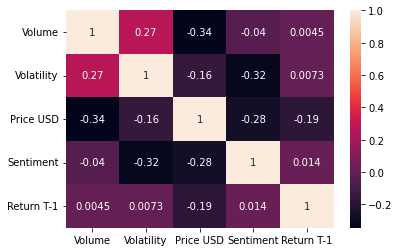

In [60]:
corr_hm(ticker = 'IROSROA')

<AxesSubplot:>

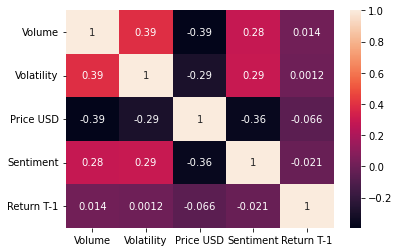

In [61]:
corr_hm('GZMNIJI')

<AxesSubplot:>

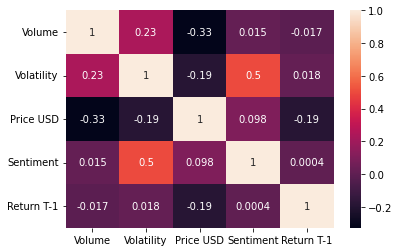

In [62]:
corr_hm('TJXKVVW')

From the correlation matrix, we can there's some level of correlation between Volatility and Sentiment, which is intuitive. 

###  2. MLR & comments on other statistical models
I start by asessing Volume with 2 variables Price USD and Volatility.

In [63]:
ticker = 'GZMNIJI'

df = tk.stock_df(stocks, ticker)
X, Y = df[['Price USD','Volatility','Sentiment']], df['Volume']
X_train, Y_train, X_test, Y_test = tk.split_data(X, Y, train_split = 0.8)

In [64]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression()
LR.fit(X_train,Y_train)
y_predict =  LR.predict(X_test)

from sklearn.metrics import r2_score as R2
pd.DataFrame({'MSE': mse(Y_test, y_predict), 
'MAE': mae(Y_test, y_predict), 
'MAPE': mape(Y_test, y_predict),
'R2':R2(Y_test, y_predict)}, index = [ticker])

,MSE,MAE,MAPE,R2
GZMNIJI,25455.174651,84.586909,0.320795,0.091062


This gives a very bad fit. 
<br>

I plot the autocorrelation plot with lag = 1, 2, 3 below

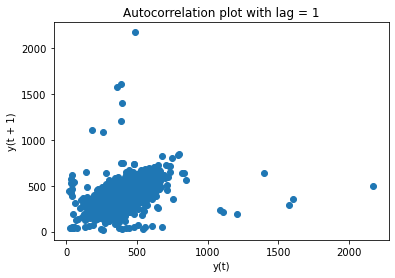

In [65]:
plt.figure()
lag_plot(df['Volume'], lag=1)
plt.title('Autocorrelation plot with lag = 1')
plt.show()

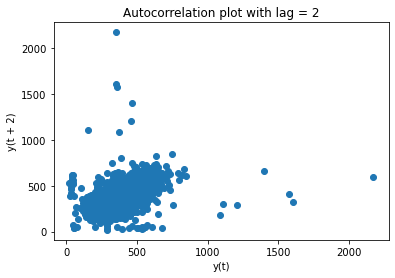

In [66]:
plt.figure()
lag_plot(df['Volume'], lag=2)
plt.title('Autocorrelation plot with lag = 2')
plt.show()

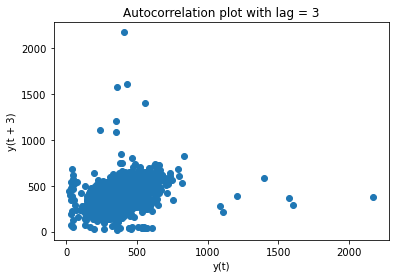

In [67]:
plt.figure()
lag_plot(df['Volume'], lag=3)
plt.title('Autocorrelation plot with lag = 3')
plt.show()

The data does not exhibits autocorrelation so might not be appropriate to use ARIMA model.

<br>
I plot the daily Volume change in %.

<AxesSubplot:xlabel='Date'>

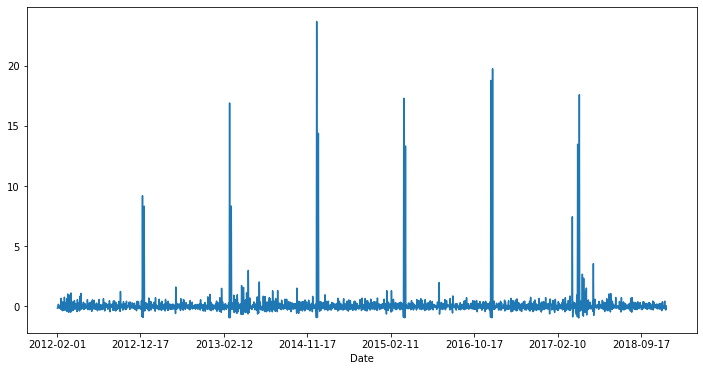

In [68]:
ticker = 'IROSROA'
df = tk.stock_df(stocks, ticker).set_index('Date')
df['Volume'].pct_change().plot(figsize = (12, 6))

<AxesSubplot:xlabel='Date'>

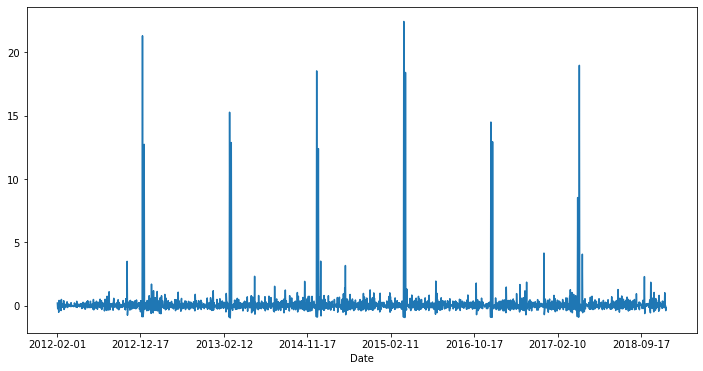

In [69]:
ticker = 'LBQCYGN'
df = tk.stock_df(stocks, ticker).set_index('Date')
df['Volume'].pct_change().plot(figsize = (12, 6))

<AxesSubplot:xlabel='Date'>

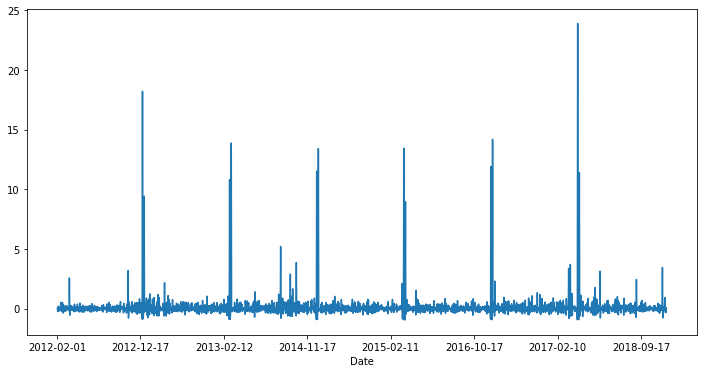

In [70]:
ticker = 'GZMNIJI'
df = tk.stock_df(stocks, ticker).set_index('Date')
df['Volume'].pct_change().plot(figsize = (12, 6))

Given the series is stationary, there aren't really volatility clustering, and I could not find many empirical research examples using GARCH models, I avoid it, although GARCH is used to model and forecast the volatility of financial time series data frequently. 

###  3. LSTM
#### 3.1 LSTM with historical Volume
Besides statistical model, Artificial Neural Networks models are also used to predict stock volume, although more work is done adopting various techniques to predict stock prices. It is noted that LSTM contributes to a superior prediction of the change in volume[7]. Here, I adopt the LSTM model mentioned with Volume and Price as the input data. 

In [180]:
# stocks['ID'].unique()

With limited reference, I started with one LSTM and gradually increased. The model does not improve with more than 3 layers. 
<br>
Referencing the stock price prediction model, I added the Dropout layers after each LSTM layer.
<br>
I also chose the window size of 5 after trial and error suggested that it may have the best prediction potential.

<br>
However, optimization of the layer number and window size along with other model parameters would require additional research.

In [218]:
ticker = 'SFCZFSB'

df = tk.stock_df(stocks, ticker).set_index('Date')

In [219]:
vol_norm = tk.normalized_data(df['Volume'], -1, 1)

window_size = 5
train_split = 0.8

X, Y = tk.df_to_XY(vol_norm, window_size=5)
X_train, Y_train, X_test, Y_test = tk.split_data(X, Y, train_split)

In [220]:
model3 = tk.LSTM_layers(window_size, 1)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001))
model3.fit(X_train,Y_train, epochs=2)

Epoch 1/2
46/46 [==============================] - 7s 45ms/step - loss: 0.1159
Epoch 2/2
46/46 [==============================] - 3s 57ms/step - loss: 0.0089


12/12 [==============================] - 1s 11ms/step


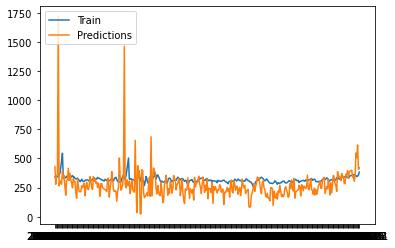

In [221]:
test_predictions = model3.predict(X_test)
vol_predict = scaler.inverse_transform(test_predictions)
results = pd.DataFrame(data={'Test Predictions':vol_predict.flatten(), 
                              'Actuals':df.iloc[-len(vol_predict):]['Volume']})

plt.plot(results[['Test Predictions', 'Actuals']])
plt.legend(['Train', 'Predictions', 'Actuals'], loc='upper left')

In [222]:
predictions = test_predictions.flatten()
res3 = tk.performance_measure(model3, X_test, Y_test.flatten(), 'LSTM Vol')
res3

12/12 [==============================] - 0s 10ms/step


,MSE,MAE,MAPE,Accuracy
LSTM Vol,0.006315,0.048798,0.204366,0.795634


#### 3.1 LSTM incorporating Pirce

In [194]:
vol_norm = tk.normalized_data(df['Volume'], -1, 1)
px_norm = tk.normalized_data(df['Price USD'], -1, 1)


window_size = 5
train_split = 0.8

X, Y = tk.df_to_XY_add_sent(vol_norm, px_norm, window_size=5)
X_train, Y_train, X_test, Y_test = tk.split_data(X, Y, train_split)

In [195]:
model4 = tk.LSTM_layers(window_size+1, 1)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001))
model4.fit(X_train,Y_train, epochs=5)

Epoch 1/5
46/46 [==============================] - 10s 95ms/step - loss: 0.1018
Epoch 2/5
46/46 [==============================] - 4s 91ms/step - loss: 0.0085
Epoch 3/5
46/46 [==============================] - 4s 89ms/step - loss: 0.0084
Epoch 4/5
46/46 [==============================] - 5s 112ms/step - loss: 0.0082
Epoch 5/5
46/46 [==============================] - 5s 113ms/step - loss: 0.0083


12/12 [==============================] - 2s 12ms/step


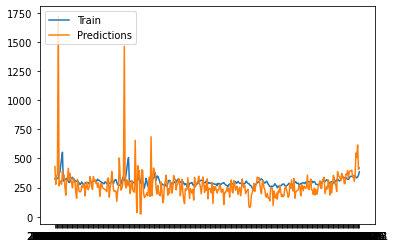

In [196]:
test_predictions = model4.predict(X_test)
vol_predict = scaler.inverse_transform(test_predictions)
results = pd.DataFrame(data={'Test Predictions':vol_predict.flatten(), 
                              'Actuals':df.iloc[-len(vol_predict):]['Volume']})

plt.plot(results[['Test Predictions', 'Actuals']])
plt.legend(['Train', 'Predictions', 'Actuals'], loc='upper left')

In [197]:
predictions = test_predictions.flatten()
res4 = tk.performance_measure(model3, X_test, Y_test.flatten(), 'LSTM Vol Price')
res4

12/12 [==============================] - 1s 16ms/step


,MSE,MAE,MAPE,Accuracy
LSTM Vol Price,0.125564,0.346342,0.623665,0.376335


In [198]:
pd.concat([res3, res4], axis = 0 )

,MSE,MAE,MAPE,Accuracy
LSTM Vol,0.005556,0.037218,0.198817,0.801183
LSTM Vol Price,0.125564,0.346342,0.623665,0.376335


It seems that the LSTM with only historical Volume data provides far higher accuracy. 

I use it to predict the Volume.

In [249]:
# predict_vol_dict = {}
# for ticker in stock_list:
#     predict_vol_dict[ticker] = tk.predivt_LSTM_volume(ticker)[0][0]

1/1 [==============================] - 1s 1s/step


In [250]:
# predict_vol_dict

In [289]:
volume_predict = pd.DataFrame.from_dict(predict_vol_dict, orient='index')
volume_predict.head()

,0
IROSROA,669.850708
LBQCYGN,764.378052
GZMNIJI,623.249390
PREGXXP,747.742371
TJXKVVW,556.533752


In [290]:
# volume_predict.to_csv('volume_predict.csv') 

In [291]:
px_predict = pd.read_csv('Price USD predict.csv')
px_predict.head()

,Unnamed: 0,Price in USD,Accuracy,Country
0,IROSROA,13.228242,0.764749,JP
1,LBQCYGN,14.302553,0.916715,US
2,GZMNIJI,15.845817,0.906883,US
3,PREGXXP,8.891578,0.903034,JP
4,TJXKVVW,17.507168,0.840952,UK


In [292]:
px_predict = px_predict.set_index(px_predict.columns[0])
volume_predict = volume_predict.rename(columns = {0:'Volume'})
value_predict = pd.concat([px_predict, volume_predict], axis = 1)
value_predict['Value traded'] = value_predict['Price in USD'] * value_predict['Volume']
value_predict

,Price in USD,Accuracy,Country,Volume,Value traded
IROSROA,13.228242,0.764749,JP,669.850708,8860.947269
LBQCYGN,14.302553,0.916715,US,764.378052,10932.557597
GZMNIJI,15.845817,0.906883,US,623.249390,9875.895774
PREGXXP,8.891578,0.903034,JP,747.742371,6648.609612
TJXKVVW,17.507168,0.840952,UK,556.533752,9743.329902
...,...,...,...,...,...
FAMUDFB,17.656025,0.934795,JP,478.930298,8456.005312
NJCOVIW,21.184797,0.922241,UK,447.364655,9477.329391
FHEYTHO,18.789883,0.954563,US,526.363953,9890.317085
SUUWFLD,10.231596,0.827030,UK,443.876038,4541.560291


## REFERENCES

[1] Khalid Bin Saboor, Qurat Ul Ain Saboor, Liyan Han, Abdul Saboor Zahid, Predicting the Stock Market using Machine Learning: Long short-term Memory. *Electronic Research Journal of Engineering, Computer and Applied Sciences* Volume 2 (2020). Available from: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3810128 <br>

[2] Ruochen Xiao, Yingying Feng, Lei Yan, Yihan Ma, Predict Stock Prices with ARIMA and LSTM. *arXiv*:2209.02407v1 [q-fin.ST] 31 Aug 2022. Available from: https://arxiv.org/pdf/2209.02407.pdf <br>

[3] Shilpa Gite, Hrituja Khatavkar, Ketan Kotecha, Shilpi Srivastava, Priyam Maheshwari Neerav Pandey, Explainable stock prices prediction from financial news articles using sentiment analysis. *PeerJ Computer Science* Published 28 January 2021. Available from: https://www.semanticscholar.org/paper/Explainable-stock-prices-prediction-from-financial-Gite-Khatavkar/25a07bf9755fbfc73b11668517b8a6f54c362e4c <br>

[4] Halder Shayan, FinBERT-LSTM: Deep Learning based on stock price prediction using News Sentiment Analysis. *arXiv*:2211.07392v1 [q-fin.ST] 11 Nov 2022. Avaialble from: https://arxiv.org/pdf/2211.07392.pdf <br>

[5] S. Mohan, S. Mullapudi, S. Sammeta, P. Vijayvergia and D.C. Anastasiu. "Stock price prediction using news sentiment analysis". *2019 IEEE Fifth International Conference on Big Data Computing Service and Applications*, IEEE, 2019, pp.205-208 <br>

[6] Fauzia Mubarik, Attiya Yasmin Javid, Relationship between Stock Return, Trading Volume and Volatility: Evidence from Pakistani Stock Market (July 31, 2009). *Asia Pacific Journal of Finance and Banking Research*, Vol. 3, No. 3, July 2009. Available at SSRN: https://ssrn.com/abstract=1536053

[7] Daniel Libman, Simi Haber, Mary Schaps, Volume Prediction With Neural Networks. *Frontier in Artificial Intelligence*, 2:21, 09 October 2019. Available from: https://www.frontiersin.org/articles/10.3389/frai.2019.00021/full